In [8]:
import healpy as hp
from astropy.cosmology import Planck18 as cosmos
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fwhm = cosmos.comoving_distance(1.51).to('Mpc').value*(6*u.arcmin).to('rad').value*cosmos.h     # h^-1 Mpc
sigma = fwhm / np.sqrt(8*np.log(2))

figure:

- auto corr of low high L, in one figure
- auto corr of different z bin
- cross corr of low high L
- cross corr of differnet z bin
- cross corr of random, quasar and q-r, and covariance matrix

In [3]:
lcut = 6

In [4]:
def get_wp(file):
    dat = np.load(file)
    wp = dat.mean(axis=0)
    wp_std = dat.std(axis=0, ddof=0)*np.sqrt(dat.shape[0] - 1)
    return (wp[lcut:], wp_std[lcut:])

In [5]:
wp_dict = {
    'total': get_wp('quasar_lss_all.npy_auto.npy'),
    'high': get_wp('quasar_lss_high_L.npy_auto.npy'),
    'low': get_wp('quasar_lss_low_L.npy_auto.npy'),
    'z1': get_wp('quasar_lss_z1.npy_auto.npy'),
    'z2': get_wp('quasar_lss_z2.npy_auto.npy'),
    'z3': get_wp('quasar_lss_z3.npy_auto.npy'),
}

In [6]:
Nbins = 15
rp_min = 3
rp_max = 100

rp_bin_cross = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_cross = (rp_bin_cross[:-1]*rp_bin_cross[1:])**0.5

sep = (np.log10(rp_max) - np.log10(rp_min)) / Nbins
rp_bin_auto = 10**(np.arange(-10, Nbins+1)*sep + np.log10(rp_min))
# rp_bin_auto = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_auto = (rp_bin_auto[:-1]*rp_bin_auto[1:])**0.5
r_p_auto =  r_p_auto[lcut:]

[]

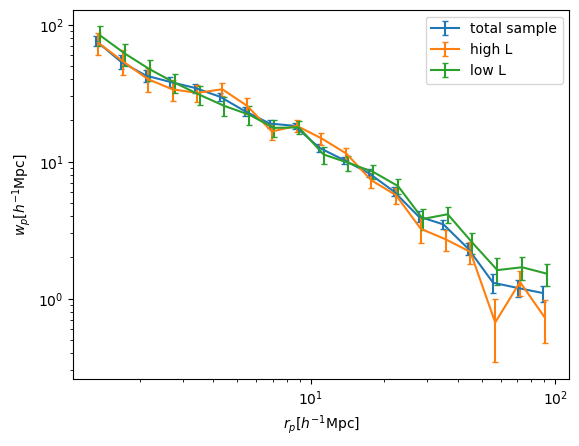

In [7]:
errorbar_kw = {'capsize': 2}

plt.errorbar(r_p_auto, *wp_dict['total'], label='total sample', **errorbar_kw)
plt.errorbar(r_p_auto*1.02, *wp_dict['high'], label='high L', **errorbar_kw)
plt.errorbar(r_p_auto*1.02**2, *wp_dict['low'], label='low L', **errorbar_kw)
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$w_p[h^{-1}\mathrm{Mpc}]$')
plt.legend()
plt.loglog()

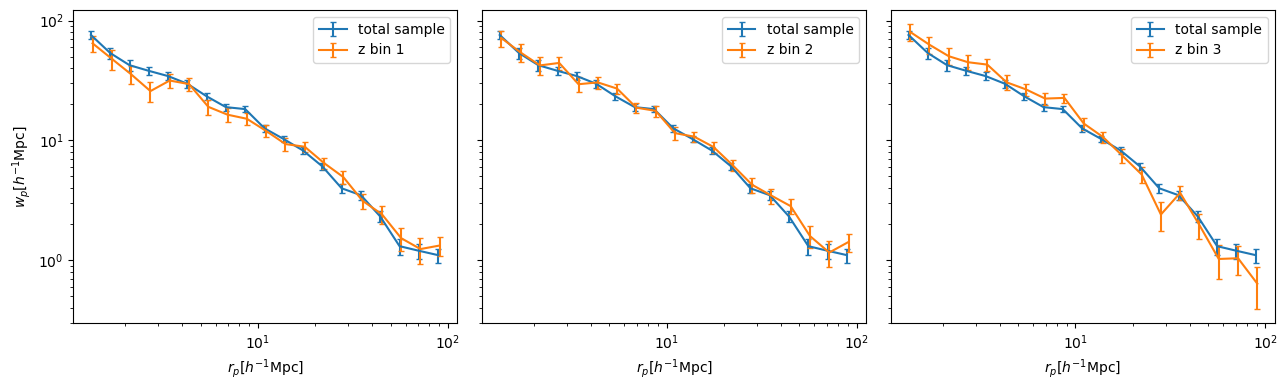

In [10]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
for i in range(3):
    axes[i].errorbar(r_p_auto, *wp_dict['total'], label='total sample', **errorbar_kw)
    axes[i].errorbar(r_p_auto*1.02, *wp_dict[f'z{i+1}'], label=f'z bin {i+1}', **errorbar_kw)
    axes[i].set_xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
    axes[i].legend()
    axes[i].loglog()
axes[0].set_ylabel(r'$w_p[h^{-1}\mathrm{Mpc}]$')
plt.tight_layout()

[]

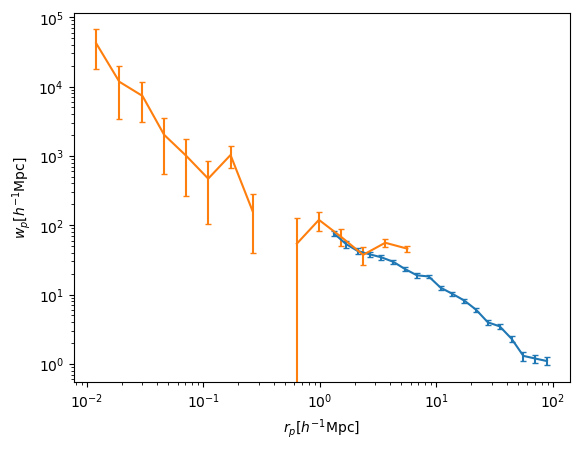

In [11]:
wp_small = pd.read_csv('small_scale')
plt.errorbar(r_p_auto, *wp_dict['total'], **errorbar_kw)
plt.errorbar(wp_small['rp'], wp_small['wp'], wp_small['wp_err'], **errorbar_kw)

plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$w_p[h^{-1}\mathrm{Mpc}]$')
# plt.legend()
plt.loglog()        # cut 0-3 points(very small scale) and the overlapping part

In [13]:
np.diff(np.log(r_p_auto))

array([0.23377053, 0.23377053, 0.23377053, 0.23377053, 0.23377053,
       0.23377053, 0.23377053, 0.23377053, 0.23377053, 0.23377053,
       0.23377053, 0.23377053, 0.23377053, 0.23377053, 0.23377053,
       0.23377053, 0.23377053, 0.23377053])

In [12]:
np.diff(np.log(wp_small['rp']))

array([0.45953233, 0.4567584 , 0.42744401, 0.43403848, 0.43780049,
       0.44118319, 0.43806627, 0.43398533, 0.4383338 , 0.43652351,
       0.4365765 , 0.43659603, 0.43689447, 0.43669226])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from data_process import jackknife_label, load_calculation_data, calculate_jackknife_variance_global
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100
z = 0
scale_factor = cosmos.Om(z) * cosmos.critical_density(z).to('M_sun/pc^3').value / h**2 * 1e6
jack_cross = {}
wpm_dict = {}

In [12]:
r_p, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_smoothed_6_tree.npy', return_rp=True)
dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_6_tree.npy')
Nside_jack = 10
quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
random_sample = np.load('../catalogue/random_quasar_lss_all.npy')

pix = jackknife_label(quasar_cata, Nside_jack)
pix_r = jackknife_label(random_sample, Nside_jack)
sampler_q = calculate_jackknife_variance_global(dat[0], dat[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True, return_jackknife=True)
jack_cross['total'] = sampler_q['jackknife']
wpm_dict['total'] = sampler_q['mean'], sampler_q['std']

In [13]:
for catalogue in ['high', 'low']:
    r_p, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_{catalogue}_L_CMB_smoothed_6_tree.npy', return_rp=True)
    dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_6_tree.npy')
    Nside_jack = 10
    quasar_cata = np.load(f'../catalogue/quasar_lss_{catalogue}_L.npy')
    random_sample = np.load('../catalogue/random_quasar_lss_all.npy')

    pix = jackknife_label(quasar_cata, Nside_jack)
    pix_r = jackknife_label(random_sample, Nside_jack)
    sampler_q = calculate_jackknife_variance_global(dat[0], dat[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True, return_jackknife=True)
    jackknife = sampler_q['jackknife']
    jack_cross[catalogue] = sampler_q['jackknife']
    wpm_dict[catalogue] = (jackknife.mean(axis=0), jackknife.std(axis=0, ddof=0)*np.sqrt(jackknife.shape[0] - 1))

In [14]:
for catalogue in ['z1', 'z2', 'z3']:
    r_p, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_{catalogue}_CMB_smoothed_6_tree.npy', return_rp=True)
    dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_random_{catalogue}_CMB_smoothed_6_tree.npy')
    Nside_jack = 10
    quasar_cata = np.load(f'../catalogue/quasar_lss_{catalogue}.npy')
    random_sample = np.load(f'../catalogue/random_{catalogue}.npy')

    pix = jackknife_label(quasar_cata, Nside_jack)
    pix_r = jackknife_label(random_sample, Nside_jack)
    sampler_q = calculate_jackknife_variance_global(dat[0], dat[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True, return_jackknife=True)
    jackknife = sampler_q['jackknife']
    jack_cross[catalogue] = sampler_q['jackknife']
    wpm_dict[catalogue] = (jackknife.mean(axis=0), jackknife.std(axis=0, ddof=0)*np.sqrt(jackknife.shape[0] - 1))

used for ploting the cov matrix

In [45]:
r_p, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_smoothed_6_tree.npy', return_rp=True)
dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_6_tree.npy')
Nside_jack = 10
quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
random_sample = np.load('../catalogue/random_quasar_lss_all.npy')

pix = jackknife_label(quasar_cata, Nside_jack)
pix_r = jackknife_label(random_sample, Nside_jack)
sampler_q = calculate_jackknife_variance_global(dat[0], dat[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True, return_jackknife=True)
sampler_qonly = calculate_jackknife_variance_global(dat[0], dat[1], pix, norm_cov=True, return_jackknife=True)
sampler_ronly = calculate_jackknife_variance_global(dat_r[0], dat_r[1], pix_r, norm_cov=True, return_jackknife=True)

In [ ]:
def rp2index(rp):
    y0 = 0
    y1 = 14
    x0 = np.log10(r_p[0])
    x1 = np.log10(r_p[-1])
    return (np.log10(rp) - x0) / (x1 - x0) * (y1 - y0) + y0
minor_ticks = np.array([
    i*10**(j)
    for j in range(0, 2)
    for i in range(2, 10)
])
minor_ticks = minor_ticks[np.logical_and(minor_ticks <= r_p[-1], minor_ticks >= r_p[0])]
major_ticks = [10, 100]
tick_labels = ['$10$', '$10^2$']

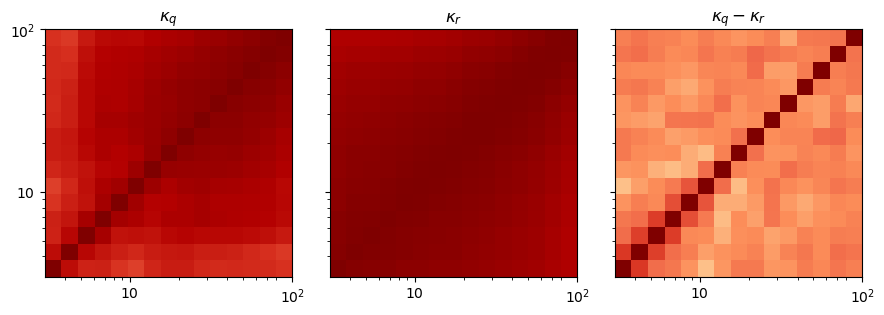

In [99]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 3))
kws = {'vmin': -1, 'vmax': 1, 'origin': 'lower', 'cmap': 'OrRd'}
axes[0].imshow(sampler_qonly['cov'], **kws)
axes[1].imshow(sampler_ronly['cov'], **kws)
axes[2].imshow(sampler_q['cov'], **kws)


axes[0].set_title(r'$\kappa_q$')
axes[1].set_title(r'$\kappa_r$')
axes[2].set_title(r'$\kappa_q-\kappa_r$')
# axes[0].tick_params(labelrotation=45)

for i in range(3):
    axes[i].set_xticks(rp2index(minor_ticks), minor=True)
    axes[i].set_xticks(rp2index(major_ticks))
    axes[i].set_xticklabels(tick_labels)

axes[0].set_yticks(rp2index(minor_ticks), minor=True)
axes[0].set_yticks(rp2index(major_ticks))
axes[0].set_yticklabels(tick_labels)

plt.tight_layout()


[]

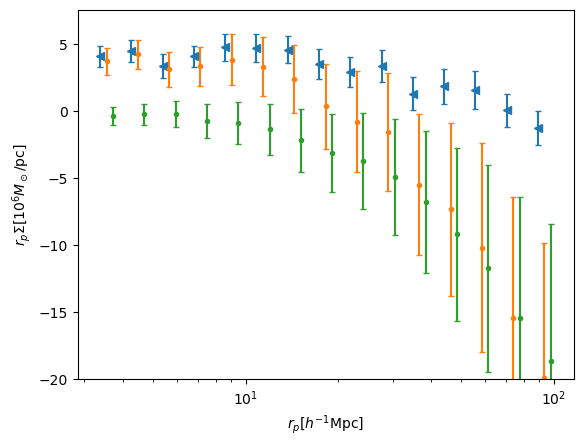

In [101]:
plt.errorbar(r_p, r_p*sampler_q['mean'], r_p*sampler_q['std'], **errorbar_kw, fmt='<')
plt.errorbar(r_p*1.05, r_p*sampler_qonly['mean'], r_p*sampler_qonly['std'], **errorbar_kw, fmt='.')
plt.errorbar(r_p*1.05**2, r_p*sampler_ronly['mean'], r_p*sampler_ronly['std'], **errorbar_kw, fmt='.')
plt.ylim(bottom=-20)
plt.ylabel(r'$r_p \Sigma[10^6 M_\odot /\mathrm{pc}]$')
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.semilogx()

[]

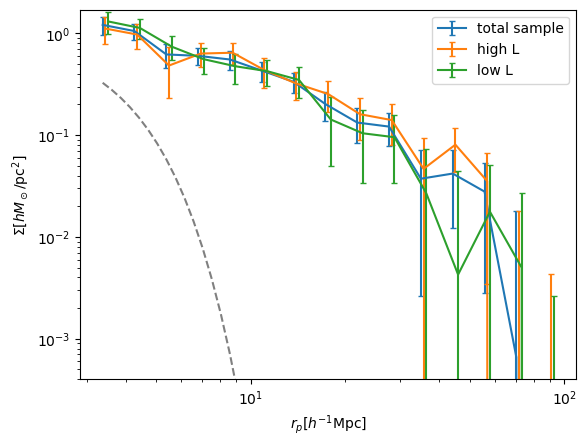

In [16]:
errorbar_kw = {'capsize': 2}

r_pp = np.geomspace(r_p[0], r_p[-1], 50)

plt.errorbar(r_p, *wpm_dict['total'], label='total sample', **errorbar_kw)
plt.errorbar(r_p*1.02, *wpm_dict['high'], label='high L', **errorbar_kw)
plt.errorbar(r_p*1.02**2, *wpm_dict['low'], label='low L', **errorbar_kw)
plt.plot(r_pp, np.exp(-r_pp*r_pp/(2*sigma*sigma)), '--', color='grey')

plt.ylim(bottom=4e-4)

plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$\Sigma[h M_\odot /\mathrm{pc}^2]$')
plt.legend()
plt.loglog()

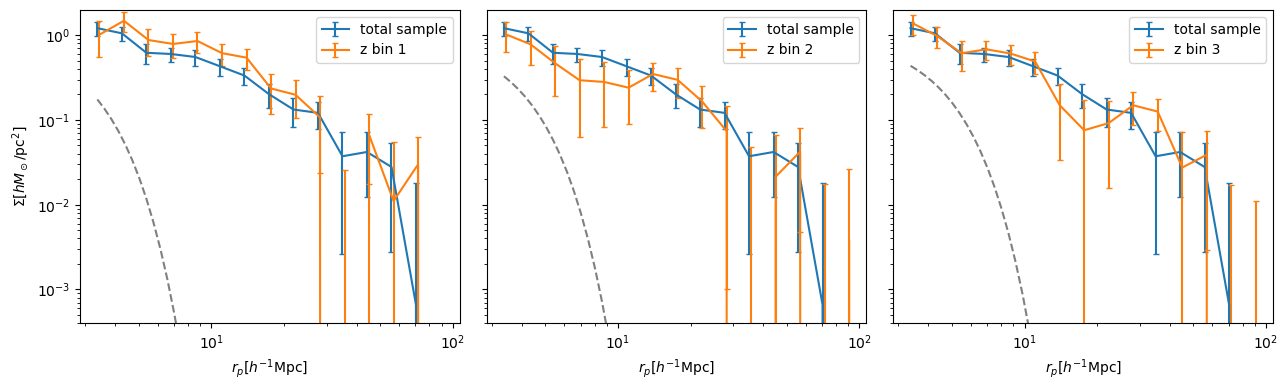

In [17]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(13, 4))

for i in range(3):
    zbar = np.load(f'../catalogue/quasar_lss_z{i+1}.npy')['z'].mean()
    fwhm1 = cosmos.comoving_distance(zbar).to('Mpc').value*(6*u.arcmin).to('rad').value*cosmos.h     # h^-1 Mpc
    sigma1 = fwhm1 / np.sqrt(8*np.log(2))

    axes[i].errorbar(r_p, *wpm_dict['total'], label='total sample', **errorbar_kw)
    axes[i].errorbar(r_p*1.02, *wpm_dict[f'z{i+1}'], label=f'z bin {i+1}', **errorbar_kw)
    axes[i].plot(r_pp, np.exp(-r_pp*r_pp/(2*sigma1*sigma1)), '--', color='grey')
    axes[i].set_ylim(bottom=4e-4)

    axes[i].set_xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
    axes[i].legend()
    axes[i].loglog()

axes[0].set_ylabel(r'$\Sigma[h M_\odot /\mathrm{pc}^2]$')
plt.tight_layout()

In [18]:
def rp2index(rp, rprange, index_range):
    y0, y1 = index_range
    x0 = np.log10(rprange[0])
    x1 = np.log10(rprange[-1])
    return (np.log10(rp) - x0) / (x1 - x0) * (y1 - y0) + y0
minor_ticks = np.array([
    i*10**(j)
    for j in range(-1, 2)
    for i in range(2, 10)
])
major_ticks = np.array([0.1, 1, 10, 100])
tick_labels = np.array(['$10^{-1}$', '$1$', '$10$', '$10^2$'])

index_minor = np.logical_and(minor_ticks <= r_p_auto[-1], minor_ticks >= r_p_auto[0])
index_major = np.logical_and(major_ticks <= r_p_auto[-1], major_ticks >= r_p_auto[0])
minor_ticks1 = minor_ticks[index_minor]
major_ticks1 = major_ticks[index_major]
tick_labels1 = tick_labels[index_major]

index_minor = np.logical_and(minor_ticks <= r_p[-1], minor_ticks >= r_p[0])
index_major = np.logical_and(major_ticks <= r_p[-1], major_ticks >= r_p[0])
minor_ticks2 = minor_ticks[index_minor]
major_ticks2 = major_ticks[index_major]
tick_labels2 = tick_labels[index_major]

[Text(0, 4.982393070064855, '$10$')]

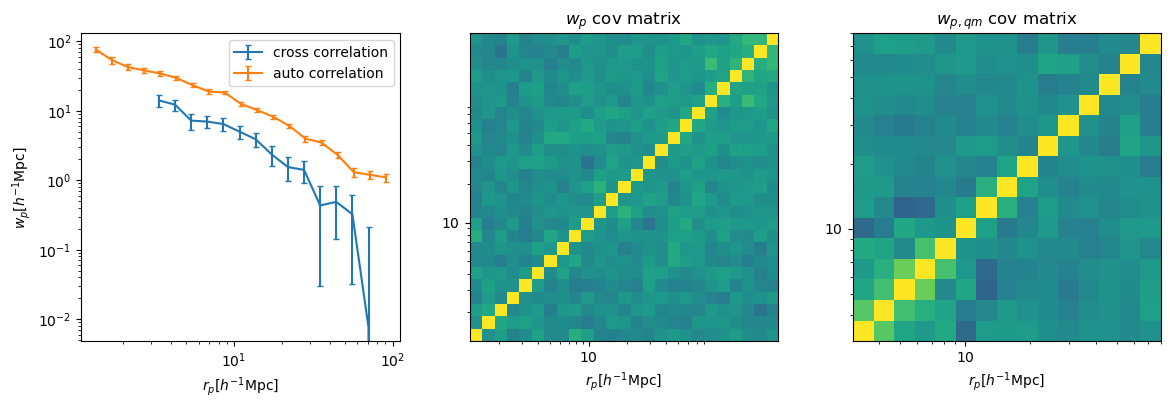

In [19]:
wpm, std = wpm_dict['total']
errorbar_kw = {'capsize': 2}

fig, axes = plt.subplots(1, 3, figsize=(14, 4))


axes[0].errorbar(r_p, wpm/scale_factor, std/scale_factor, label='cross correlation', **errorbar_kw)
axes[0].errorbar(r_p_auto*1.02, *wp_dict['total'], label='auto correlation', **errorbar_kw)
axes[0].set_xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
axes[0].set_ylabel(r'$w_p[h^{-1}\mathrm{Mpc}]$')
axes[0].legend()
axes[0].loglog()

dat = np.load('quasar_lss_all.npy_auto.npy')
cov_mat = np.cov(dat, ddof=0, rowvar=False)*(dat.shape[0]-1)
std = np.sqrt([cov_mat[i,i] for i in range(cov_mat.shape[0])])
norm_cov = cov_mat / (std.reshape(-1, 1) @ std.reshape(1, -1))

kws = {'vmin': -1, 'vmax': 1, 'origin': 'lower'}

axes[1].imshow(norm_cov, **kws)
axes[1].set_title(r'$w_p$ cov matrix')
axes[1].set_xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')

axes[1].set_xticks(rp2index(minor_ticks1, (r_p_auto[0], r_p_auto[-1]), (0, len(r_p_auto))), minor=True)
axes[1].set_xticks(rp2index(major_ticks1, (r_p_auto[0], r_p_auto[-1]), (0, len(r_p_auto))))
axes[1].set_xticklabels(tick_labels1)

axes[1].set_yticks(rp2index(minor_ticks1, (r_p_auto[0], r_p_auto[-1]), (0, len(r_p_auto))), minor=True)
axes[1].set_yticks(rp2index(major_ticks1, (r_p_auto[0], r_p_auto[-1]), (0, len(r_p_auto))))
axes[1].set_yticklabels(tick_labels1)

axes[2].imshow(sampler_q['cov'], **kws)
axes[2].set_title(r'$w_{p, qm}$ cov matrix')
axes[2].set_xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')


axes[2].set_xticks(rp2index(minor_ticks2, (r_p[0], r_p[-1]), (0, len(r_p))), minor=True)
axes[2].set_xticks(rp2index(major_ticks2, (r_p[0], r_p[-1]), (0, len(r_p))))
axes[2].set_xticklabels(tick_labels2)

axes[2].set_yticks(rp2index(minor_ticks2, (r_p[0], r_p[-1]), (0, len(r_p))), minor=True)
axes[2].set_yticks(rp2index(major_ticks2, (r_p[0], r_p[-1]), (0, len(r_p))))
axes[2].set_yticklabels(tick_labels2)

In [23]:
wpm, std_m = wpm_dict['total']
wp, std = wp_dict['total']

In [34]:
wp2 = wp[4:]
std2 = std[4:]
wpm2 = wpm / scale_factor
stdm2 = std_m / scale_factor

In [39]:
bq = wp2 / wpm2

In [42]:
bq_std = ((wp2 / std2)**2 + (wpm2 / stdm2)**2)**0.5 * abs(bq)

In [44]:
np.average(bq, weights=bq_std**(-2))

2.73243390408119

In [26]:
sampler_q['cov']

array([[ 1.00000000e+00,  4.68397020e-01,  2.02428342e-01,
         1.33955224e-01, -3.65055969e-02, -3.00888794e-01,
        -4.95978249e-02,  1.24289139e-01,  1.20125561e-01,
        -5.34837095e-02, -3.32202981e-02,  1.06820715e-01,
         3.84084414e-02,  1.47325634e-01,  8.25064962e-02],
       [ 4.68397020e-01,  1.00000000e+00,  4.26255439e-01,
         1.88032527e-01,  8.91056562e-02, -9.48136152e-02,
        -2.71731192e-02,  1.05549541e-02,  6.25840517e-02,
        -7.82723705e-02,  6.02002142e-02,  1.33251342e-01,
         9.40533195e-03,  1.93520791e-01,  1.50978223e-01],
       [ 2.02428342e-01,  4.26255439e-01,  1.00000000e+00,
         4.43678532e-01,  2.32039403e-02,  6.81137002e-03,
        -1.91838447e-01, -1.45508295e-02,  1.41501448e-02,
        -1.18671423e-01, -6.55514754e-02,  6.49443932e-02,
         1.54862842e-02,  9.37735885e-02,  8.51306181e-02],
       [ 1.33955224e-01,  1.88032527e-01,  4.43678532e-01,
         1.00000000e+00,  3.51588711e-01,  1.14575958